In [41]:
import requests
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
pd.set_option('display.max_columns', 50)

In [2]:
names = ['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens', 'Buffalo Bills',
         'Carolina Panthers', 'Chicago Bears', 'Cincinnati Bengals', 'Cleveland Browns',
         'Dallas Cowboys', 'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
         'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars', 'Kansas City Chiefs',
         'LA Chargers', 'LA Rams', 'Miami Dolphins', 'Minnesota Vikings', 'New York Giants',
         'New York Jets', 'New England Patriots', 'New Orleans Saints', 'Oakland Raiders', 
         'Philadelphia Eagles', 'Pittsburgh Steelers', 'San Francisco 49ers', 
         'Seattle Seahawks', 'Tampa Bay Buccaneers', 'Tennessee Titans', 'Washington Redskins']

In [16]:
def scrape(year):
    
    
    url_start = 'http://www.espn.com/nfl/statistics/team/_/stat/'
    df = pd.read_html(url_start+ 'total/year/' + str(year))[0]
    df.columns = df.iloc[0]
    df = df.drop([0])
    df = df.drop(columns=['RK'])
    df['Year'] = year
    new_names = [(i,'O_' + i ) for i in df.iloc[:, 1:-1].columns.values]
    df.rename(columns = dict(new_names), inplace=True)
    
    df_de = pd.read_html(url_start + 'total/position/defense/year/'+ str(year))[0]
    df_de.columns = df_de.iloc[0]
    df_de = df_de.drop([0])
    df_de = df_de.drop(columns=['RK'])
    new_names = [(i,'D_' + i ) for i in df_de.iloc[:, 1:-1].columns.values]
    df_de.rename(columns = dict(new_names), inplace=True)
    
    df_ds = pd.read_html(url_start + 'defense/year/' + str(year))[0]
    df_ds.columns = df_ds.iloc[1]
    df_ds = df_ds.drop([0,1])
    df_ds = df_ds.drop(columns=['RK'])
    df_ds.head()
    
    df_da = pd.read_html(url_start + 'defense/position/defense/year/' + str(year))[0]
    df_da.columns = df_da.iloc[1]
    df_da = df_da.drop([0,1])
    df_da = df_da.drop(columns=['RK'])
    new_names = [(i, i + '_A') for i in df_da.iloc[:, 1:].columns.values]
    df_da.rename(columns = dict(new_names), inplace=True)
    df_da.head()

    dfs = [df, df_de, df_ds, df_da]
    df_ready = reduce(lambda left,right: pd.merge(left,right,on='TEAM'), dfs)
    df_ready = df_ready.sort_values(by=['TEAM'])
    df_ready['NAME'] = [i.split(' ')[-1] for i in names]
    
    dfs = pd.read_html('http://www.espn.com/nfl/standings/_/season/'+str(year)+'/group/league')
    df_con = pd.concat([dfs[1] , dfs[3]], axis=1)
    df_con['NAME'] = [i.split(' ')[-1] for i in df_con[0]]
    df_con.drop(columns = [0, 'HOME', 'AWAY', 'DIV', 'CONF', 'PF', 'PA',
                           'DIFF', 'STRK'], inplace = True)
    
    df_final = pd.merge(df_con, df_ready, how='outer', on='NAME')
    return df_final

In [21]:
def combine_scrape(start_year, end_year):
    years = list(range(start_year, end_year+1))
    combined_df = pd.DataFrame()
    
    for year in years:
        temp_df = scrape(year)
        combined_df = combined_df.append(temp_df)
        
    combined_df = combined_df.reset_index(drop=True)
    return combined_df

In [22]:
df = combine_scrape(2002, 2018)

In [145]:
df.head()

,W,L,T,PCT,NAME,TEAM,O_YDS,O_YDS/G,O_PASS,O_P YDS/G,O_RUSH,O_R YDS/G,O_PTS,O_PTS/G,Year,D_YDS,D_YDS/G,D_PASS,D_P YDS/G,D_RUSH,D_R YDS/G,D_PTS,PTS/G,SOLO,AST,TOTAL,SACK,YDSL,PD,INT,YDS,LONG,TD_INT,FF,REC,TD_FUM,SOLO_A,AST_A,TOTAL_A,SACK_A,YDSL_A,PD_A,INT_A,YDS_A,LONG_A,TD_INT_A,FF_A,REC_A,TD_FUM_A
0,12.0,4.0,0.0,0.750,Eagles,Philadelphia,5604.0,350.3,3384.0,211.5,2220.0,138.8,415.0,25.9,2002,4754.0,297.1,3094.0,193.4,1660.0,103.8,241.0,15.1,792.0,220.0,1012.0,56.0,348.0,230.0,15.0,193.0,80.0,2.0,29.0,22.0,1.0,826.0,305.0,1131.0,36.0,222.0,230.0,11.0,86.0,35.0,0.0,21.0,13.0,1.0
1,12.0,4.0,0.0,0.750,Packers,Green Bay,5560.0,347.5,3627.0,226.7,1933.0,120.8,398.0,24.9,2002,4985.0,311.6,2987.0,186.7,1998.0,124.9,328.0,20.5,798.0,307.0,1105.0,43.0,241.0,244.0,24.0,516.0,89.0,4.0,22.0,21.0,0.0,883.0,362.0,1245.0,27.0,196.0,219.0,16.0,327.0,65.0,0.0,15.0,12.0,1.0
2,12.0,4.0,0.0,0.750,Buccaneers,Tampa Bay,5002.0,312.6,3445.0,215.3,1557.0,97.3,346.0,21.6,2002,4044.0,252.8,2490.0,155.6,1554.0,97.1,196.0,12.3,788.0,223.0,1011.0,43.0,295.0,251.0,31.0,494.0,97.0,4.0,18.0,7.0,1.0,831.0,314.0,1145.0,41.0,220.0,219.0,10.0,143.0,51.0,3.0,21.0,11.0,0.0
3,11.0,5.0,0.0,0.688,Titans,Tennessee,5272.0,329.5,3320.0,207.5,1952.0,122.0,367.0,22.9,2002,4964.0,310.3,3540.0,221.3,1424.0,89.0,324.0,20.3,778.0,214.0,992.0,40.0,213.0,223.0,18.0,198.0,32.0,3.0,15.0,11.0,1.0,851.0,224.0,1075.0,21.0,121.0,194.0,15.0,179.0,82.0,2.0,11.0,10.0,0.0
4,11.0,5.0,0.0,0.688,Raiders,Oakland,6237.0,389.8,4475.0,279.7,1762.0,110.1,450.0,28.1,2002,4979.0,311.2,3526.0,220.4,1453.0,90.8,304.0,19.0,827.0,186.0,1013.0,43.0,261.0,224.0,21.0,347.0,98.0,3.0,11.0,10.0,0.0,907.0,270.0,1177.0,36.0,214.0,201.0,10.0,226.0,84.0,1.0,17.0,9.0,0.0


In [251]:
cols = []
count = 1
for column in df1.columns:
    cols.append(column)



In [138]:
df[cols] = df[cols].astype(float)
df['Year'] = df['Year'].astype(int)

In [133]:
df.rename(columns={'TD_1': 'TD_INT',
                  'TD_2': 'TD_FUM',
                  'TD_A_1': 'TD_INT_A',
                  'TD_A_2': 'TD_FUM_A'},
         inplace = True)

In [ ]:
df.to_csv('df.csv')

In [3]:
df1 = pd.read_csv('df.csv')

In [4]:
df1 = df1.drop(columns=['Unnamed: 0'])

In [5]:
df1.head()

,W,L,T,PCT,NAME,TEAM,O_YDS,O_YDS/G,O_PASS,O_P YDS/G,O_RUSH,O_R YDS/G,O_PTS,O_PTS/G,Year,D_YDS,D_YDS/G,D_PASS,D_P YDS/G,D_RUSH,D_R YDS/G,D_PTS,PTS/G,SOLO,AST,TOTAL,SACK,YDSL,PD,INT,YDS,LONG,TD_INT,FF,REC,TD_FUM,SOLO_A,AST_A,TOTAL_A,SACK_A,YDSL_A,PD_A,INT_A,YDS_A,LONG_A,TD_INT_A,FF_A,REC_A,TD_FUM_A
0,12.0,4.0,0.0,0.750,Eagles,Philadelphia,5604.0,350.3,3384.0,211.5,2220.0,138.8,415.0,25.9,2002,4754.0,297.1,3094.0,193.4,1660.0,103.8,241.0,15.1,792.0,220.0,1012.0,56.0,348.0,230.0,15.0,193.0,80.0,2.0,29.0,22.0,1.0,826.0,305.0,1131.0,36.0,222.0,230.0,11.0,86.0,35.0,0.0,21.0,13.0,1.0
1,12.0,4.0,0.0,0.750,Packers,Green Bay,5560.0,347.5,3627.0,226.7,1933.0,120.8,398.0,24.9,2002,4985.0,311.6,2987.0,186.7,1998.0,124.9,328.0,20.5,798.0,307.0,1105.0,43.0,241.0,244.0,24.0,516.0,89.0,4.0,22.0,21.0,0.0,883.0,362.0,1245.0,27.0,196.0,219.0,16.0,327.0,65.0,0.0,15.0,12.0,1.0
2,12.0,4.0,0.0,0.750,Buccaneers,Tampa Bay,5002.0,312.6,3445.0,215.3,1557.0,97.3,346.0,21.6,2002,4044.0,252.8,2490.0,155.6,1554.0,97.1,196.0,12.3,788.0,223.0,1011.0,43.0,295.0,251.0,31.0,494.0,97.0,4.0,18.0,7.0,1.0,831.0,314.0,1145.0,41.0,220.0,219.0,10.0,143.0,51.0,3.0,21.0,11.0,0.0
3,11.0,5.0,0.0,0.688,Titans,Tennessee,5272.0,329.5,3320.0,207.5,1952.0,122.0,367.0,22.9,2002,4964.0,310.3,3540.0,221.3,1424.0,89.0,324.0,20.3,778.0,214.0,992.0,40.0,213.0,223.0,18.0,198.0,32.0,3.0,15.0,11.0,1.0,851.0,224.0,1075.0,21.0,121.0,194.0,15.0,179.0,82.0,2.0,11.0,10.0,0.0
4,11.0,5.0,0.0,0.688,Raiders,Oakland,6237.0,389.8,4475.0,279.7,1762.0,110.1,450.0,28.1,2002,4979.0,311.2,3526.0,220.4,1453.0,90.8,304.0,19.0,827.0,186.0,1013.0,43.0,261.0,224.0,21.0,347.0,98.0,3.0,11.0,10.0,0.0,907.0,270.0,1177.0,36.0,214.0,201.0,10.0,226.0,84.0,1.0,17.0,9.0,0.0


0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


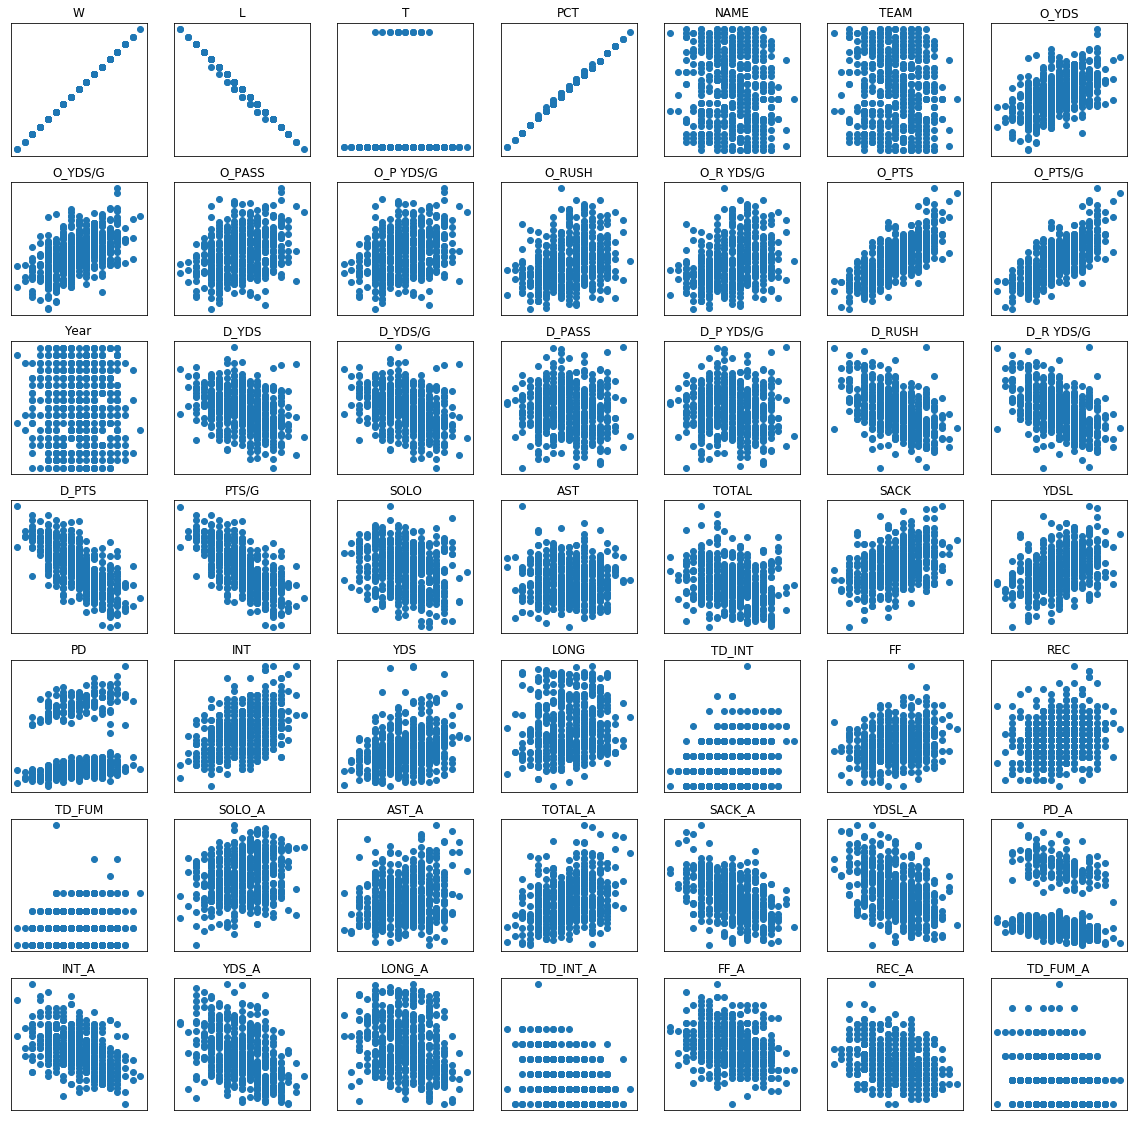

In [6]:
x = df1.W
fig, axs = plt.subplots(7, 7, figsize=(20,20))
r = 0
c = 0
t = 1
for col, row in df1.iteritems(): 

    print(r , c )
    axs[r, c].scatter(x, row)
    axs[r, c].set_title(col)
    axs[r, c].set_xticks([])
    axs[r, c].set_yticks([])
    c += 1
    t += 1
    r = (t-1)//7

    if c > 6:
        c = 0
    
    
#     c +=1 
#     while c < 7:
#         l = 0
# for ax in axs:


plt.show()

In [284]:
df1.corr()

,W,L,T,PCT,O_YDS,O_YDS/G,O_PASS,O_P YDS/G,O_RUSH,O_R YDS/G,O_PTS,O_PTS/G,Year,D_YDS,D_YDS/G,D_PASS,D_P YDS/G,D_RUSH,D_R YDS/G,D_PTS,PTS/G,SOLO,AST,TOTAL,SACK,YDSL,PD,INT,YDS,LONG,TD_INT,FF,REC,TD_FUM,SOLO_A,AST_A,TOTAL_A,SACK_A,YDSL_A,PD_A,INT_A,YDS_A,LONG_A,TD_INT_A,FF_A,REC_A,TD_FUM_A
W,1.000000,-0.998304,-0.009050,0.999581,0.526763,0.526730,0.341848,0.341864,0.351774,0.351748,0.745062,0.745136,-0.003301,-0.356528,-0.356501,-0.086238,-0.086267,-0.492131,-0.492214,-0.678317,-0.678557,-0.257764,-0.030250,-0.259261,0.406679,0.418599,0.110305,0.437583,0.299260,0.148396,0.224589,0.235136,0.211749,0.138567,0.230297,0.194594,0.358033,-0.461500,-0.456381,-0.115983,-0.483618,-0.442208,-0.227137,-0.392919,-0.295274,-0.324918,-0.215287
L,-0.998304,1.000000,-0.049180,-0.999569,-0.531705,-0.531675,-0.346285,-0.346301,-0.352757,-0.352733,-0.746705,-0.746771,-0.003298,0.355619,0.355592,0.084092,0.084122,0.493627,0.493713,0.676825,0.677050,0.264814,0.023250,0.259439,-0.412706,-0.425028,-0.106402,-0.435004,-0.296277,-0.144464,-0.220409,-0.234850,-0.210055,-0.139324,-0.223768,-0.201571,-0.359224,0.459837,0.454719,0.120054,0.486256,0.441547,0.226961,0.392780,0.296008,0.326185,0.215360
T,-0.009050,-0.049180,1.000000,0.019867,0.095464,0.095507,0.083076,0.083079,0.023952,0.023984,0.043178,0.043041,0.113282,0.008441,0.008462,0.035125,0.035117,-0.035578,-0.035619,0.012000,0.012245,-0.126269,0.119619,-0.008266,0.111686,0.118846,-0.064840,-0.035499,-0.045213,-0.064554,-0.067289,-0.000197,-0.024845,0.015784,-0.107517,0.123747,0.027640,0.019290,0.019376,-0.072250,-0.055011,0.002464,-0.001542,-0.005503,-0.018543,-0.028291,-0.005572
PCT,0.999581,-0.999569,0.019867,1.000000,0.529351,0.529319,0.344163,0.344179,0.352304,0.352280,0.746153,0.746222,0.000049,-0.356196,-0.356169,-0.085131,-0.085160,-0.493139,-0.493223,-0.677897,-0.678130,-0.261397,-0.026895,-0.259575,0.409860,0.421986,0.108363,0.436552,0.298005,0.146596,0.222663,0.235109,0.211031,0.138979,0.227086,0.198037,0.358628,-0.460869,-0.455759,-0.118097,-0.485121,-0.442060,-0.227087,-0.393047,-0.295803,-0.325725,-0.215476
O_YDS,0.526763,-0.531705,0.095464,0.529351,1.000000,1.000000,0.859623,0.859607,0.270903,0.270937,0.821020,0.821045,0.261116,0.099011,0.099054,0.299811,0.299814,-0.257154,-0.257251,-0.026546,-0.026967,-0.383780,0.011703,-0.335893,0.196463,0.233799,-0.184573,0.036280,-0.000839,-0.036654,0.009719,0.052941,-0.024832,0.070475,0.132777,0.165896,0.255169,-0.454005,-0.436123,-0.266210,-0.289248,-0.243758,-0.094628,-0.176652,-0.259071,-0.269499,-0.097741
O_YDS/G,0.526730,-0.531675,0.095507,0.529319,1.000000,1.000000,0.859647,0.859631,0.270858,0.270892,0.821023,0.821047,0.261190,0.099080,0.099122,0.299890,0.299893,-0.257148,-0.257245,-0.026481,-0.026902,-0.383788,0.011695,-0.335908,0.196431,0.233760,-0.184649,0.036223,-0.000865,-0.036678,0.009723,0.052945,-0.024799,0.070480,0.132727,0.165873,0.255109,-0.454016,-0.436132,-0.266287,-0.289221,-0.243730,-0.094632,-0.176635,-0.259046,-0.269503,-0.097711
O_PASS,0.341848,-0.346285,0.083076,0.344163,0.859623,0.859647,1.000000,1.000000,-0.258949,-0.258914,0.661695,0.661613,0.309011,0.204629,0.204695,0.327226,0.327268,-0.114032,-0.114135,0.118632,0.118230,-0.307009,0.061577,-0.222584,0.107939,0.151542,-0.251881,-0.054254,-0.064323,-0.036209,-0.021146,0.003019,-0.061373,0.064930,-0.009076,0.100972,0.084505,-0.360640,-0.320171,-0.236617,-0.137701,-0.108886,-0.022305,-0.026421,-0.210401,-0.223767,-0.067458
O_P YDS/G,0.341864,-0.346301,0.083079,0.344179,0.859607,0.859631,1.000000,1.000000,-0.258978,-0.258944,0.661712,0.661631,0.308988,0.204637,0.204702,0.327223,0.327264,-0.114014,-0.114116,0.118624,0.118222,-0.307003,0.061623,-0.222539,0.107931,0.151539,-0.251906,-0.054219,-0.064312,-0.036183,-0.021168,0.003048,-0.061368,0.065010,-0.009089,0.100972,0.084494,-0.360607,-0.320156,-0.236622,-0.137704,-0.108896,-0.022299,-0.026444,-0.210479,-0.223821,-0.067517
O_RUSH,0.351774,-0.352757,0.023952,0.352304,0.270903,0.270858,-0.258949,-0.258978,1.000000,0.999999,0.305

In [7]:
y = df1['W']
X = df1[['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK']]

In [8]:
model = ols(formula='y~D_RUSH+SACK_A+INT_A+INT+FF+FF_A+SACK', data=df1).fit()

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     140.6
Date:                Mon, 22 Apr 2019   Prob (F-statistic):          6.00e-117
Time:                        11:07:33   Log-Likelihood:                -1098.4
No. Observations:                 544   AIC:                             2213.
Df Residuals:                     536   BIC:                             2247.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4838      0.929     14.509      0.000      11.658      15.309
D_RUSH        -0.0025      0.000     -8.521      0.000      -0.003      -0.002
SACK_A        -0.0862      0.008    -10.876      0.000      -0.102      -0.071
INT_A         -0.2047      0.017    -11.977      0.000      -0.238      -0.171
INT            0.1577      0.017      9.410      0.000       0.125       0.191
FF             0.0538      0.017      3.110      0.002       0.020       0.088
FF_A          -0.0508      0.019     -2.679      0.008      -0.088      -0.014
SACK           0.0782      0.011      6.938      0.000       0.056       0.100
==============================================================================
Omnibus:                        2.529   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.423
Skew:                           0.163   Prob(JB):                        0.298
Kurtosis:                       3.033   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1) sik it learn

2) polynomial , interaction

3) eda

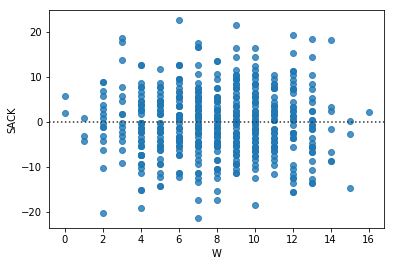

In [12]:
sns.residplot(df1., y)

In [52]:
pre = model.predict()
actual = df1.W

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

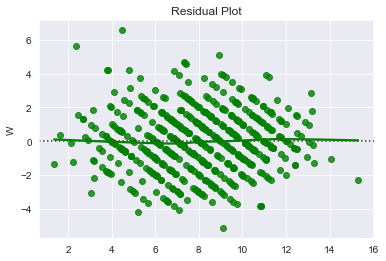

In [62]:
sns.set_style(style = 'darkgrid')
sns.residplot(pre, actual,lowess = True, color='g')
plt.title('Residual Plot')
plt

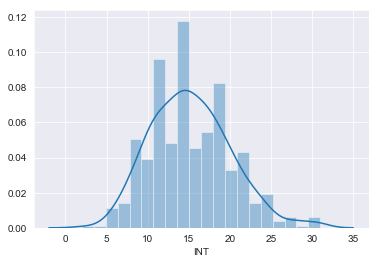

In [290]:
sns.distplot(df1["INT"])

In [33]:
sklearnmodel = LinearRegression(fit_intercept=True).fit(X, y)
r_squared = sklearnmodel.score(X, y)

In [292]:
X.columns

Index(['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK'], dtype='object')

In [293]:
print("Coefficients: ", sklearnmodel.coef_)
print("R2: ", r_squared)

Coefficients:  [-0.00250443 -0.08620344 -0.20470979  0.15767143  0.05375721 -0.05082678
  0.07815854]
R2:  0.6473369404932587


In [294]:
var = ['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK']

In [350]:
predict = sklearnmodel.predict(np.array([[1500, 62, 20, 22, 21, 20, 35]]))

In [351]:
predict

array([6.6050597])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


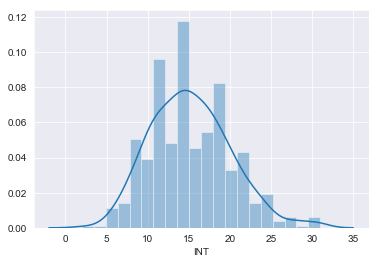

In [297]:
sns.distplot(df1['INT'])

In [298]:
picks = []
for i in range(0, 10000):
    sample = np.random.choice(df1.SACK_A, 50)
    picks.append(sample.mean())

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


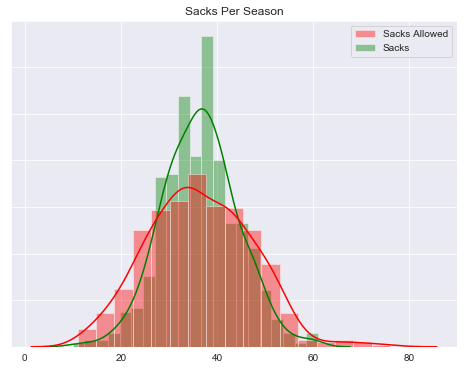

In [324]:
plt.figure(figsize=(8,6))
plt.title('Sacks Per Season', )
sns.set_style(style = 'darkgrid')
sns.distplot(df1.SACK, color='green')

sns.distplot(df1.SACK_A, color='red', axlabel=' ', label='sacks')
# plt.legend('s')
plt.legend(['Sacks Allowed', 'Sacks'])
plt.tick_params(
   axis='y', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

[]

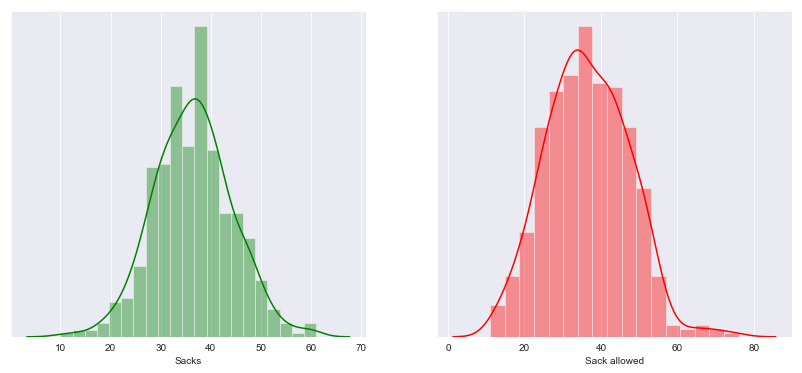

In [325]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
sns.distplot(df1.SACK, color='green', axlabel='Sacks', ax = axs[0])
axs[0].set_yticks([])
sns.distplot(df1.SACK_A, color='red', axlabel='Sack allowed', ax = axs[1])
axs[1].set_yticks([])

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


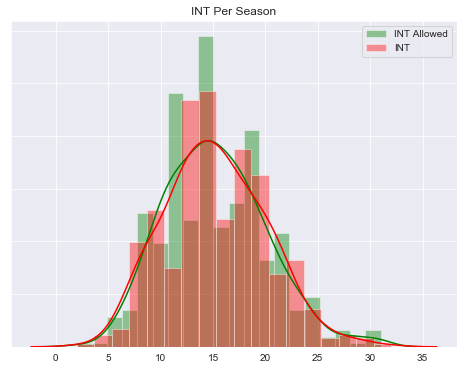

In [323]:
plt.figure(figsize=(8,6))
plt.title('INT Per Season', )
sns.set_style(style = 'darkgrid')
sns.distplot(df1.INT, color='green')
sns.distplot(df1.INT_A, color='red', axlabel=' ')
# plt.legend('s')
plt.legend(['INT Allowed', 'INT'])
plt.tick_params(
   axis='y', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

[]

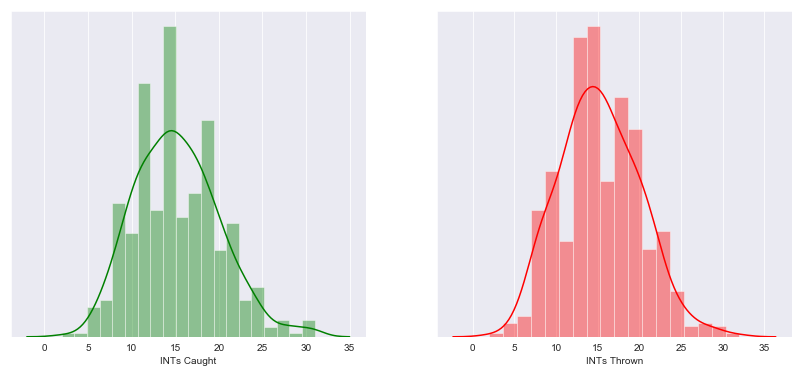

In [314]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
sns.distplot(df1.INT, color='green', axlabel='INTs Caught', ax = axs[0])
axs[0].set_yticks([])
sns.distplot(df1.INT_A, color='red', axlabel='INTs Thrown', ax = axs[1])
axs[1].set_yticks([])

In [26]:
df_plt = df1.drop(columns= ['W', 'L', 'T', 'PCT', 'NAME', 'TEAM', 'Year', 'TOTAL', 'TOTAL_A'])

In [27]:
df_plt.shape

(544, 40)

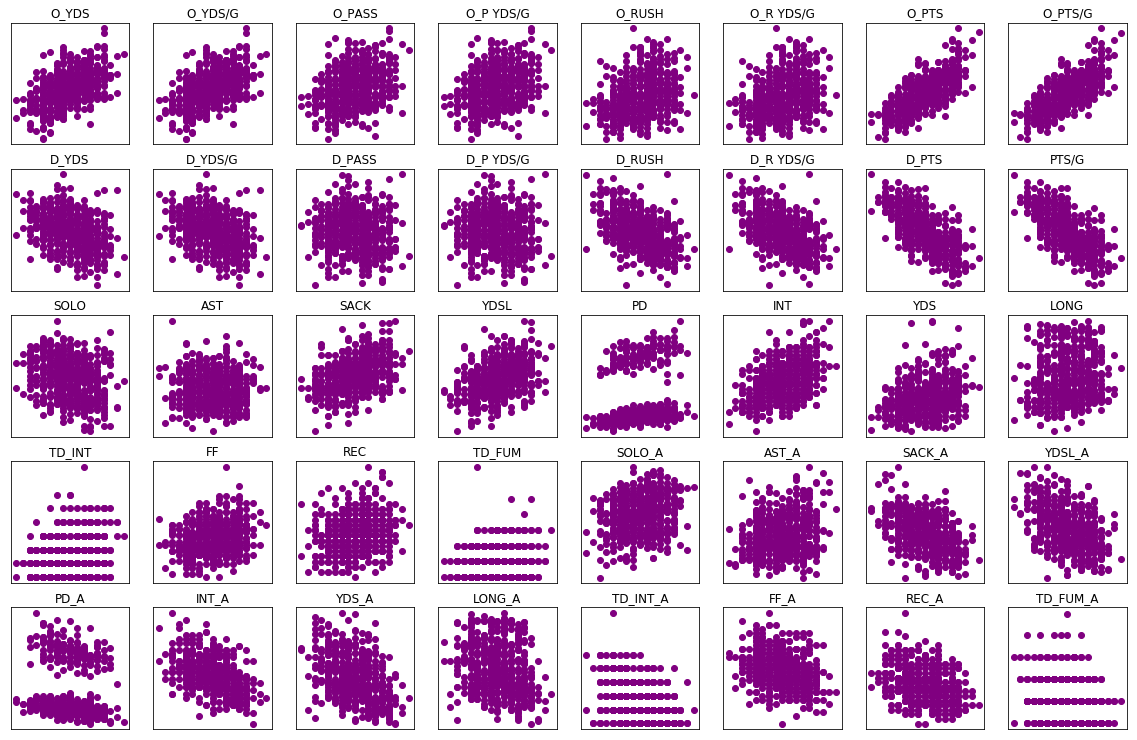

In [31]:
x = df1.W
fig, axs = plt.subplots(5, 8, figsize=(20,13))
r = 0
c = 0
t = 1
for col, row in df_plt.iteritems(): 

    axs[r, c].scatter(x, row, color='purple')
    axs[r, c].set_title(col)
    axs[r, c].set_xticks([])
    axs[r, c].set_yticks([])
    c += 1
    t += 1
    r = (t-1)//8

    if c > 7:
        c = 0
    
    
#     c +=1 
#     while c < 7:
#         l = 0
# for ax in axs:


plt.show()

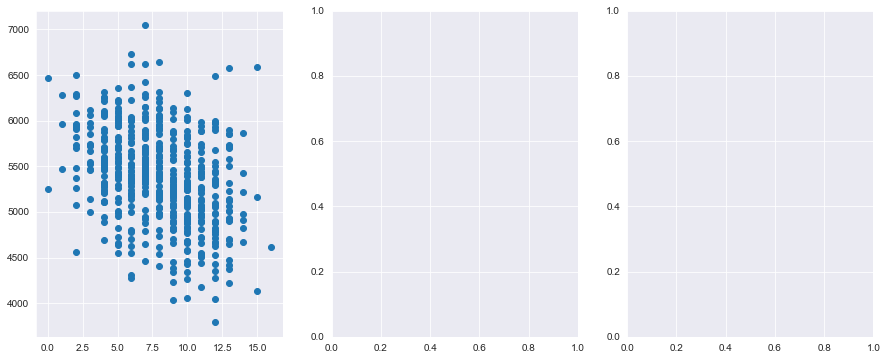

In [337]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))
axs[0].scatter(x, df1['D_YDS'])

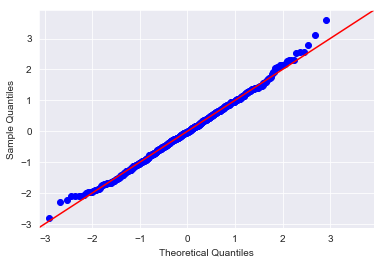

In [63]:

model_2 = ols(formula = 'y~X', data = df1).fit()
resid = model_2.resid
fig = sm.graphics.qqplot(resid, dist = stats.norm, line = '45', fit=True)

In [21]:
resid

0      0.795112
1      1.557687
2     -0.159403
3     -0.248291
4     -0.093661
5      0.401689
6      1.468476
7     -1.093272
8      2.509798
9     -1.259833
10     3.011198
11     0.245384
12     0.520961
13     0.867244
14    -2.191411
15     2.565932
16    -1.601903
17    -1.551075
18     4.190953
19    -1.715727
20     2.418092
21     0.617200
22     0.041931
23    -1.164456
24     2.091361
25    -2.302966
26     0.992996
27    -0.461438
28    -1.277165
29     1.333431
         ...   
514    1.345023
515   -0.940722
516    3.199134
517    0.559052
518    1.873319
519   -0.536770
520    2.465501
521    1.210840
522   -0.270021
523   -0.503464
524    0.354594
525    1.815585
526   -1.320235
527   -0.145141
528   -1.246897
529   -1.336748
530   -0.501207
531    0.662775
532   -1.613484
533   -2.747119
534   -1.630245
535   -0.898295
536   -0.448908
537   -2.331240
538   -0.610306
539    0.912092
540    0.452481
541   -2.278989
542    0.151777
543   -0.927070
Length: 544, dtype: floa

In [23]:
df1.iloc[18]

W                  8
L                  8
T                  0
PCT              0.5
NAME           Bills
TEAM         Buffalo
O_YDS           5591
O_YDS/G        349.4
O_PASS          3995
O_P YDS/G      249.7
O_RUSH          1596
O_R YDS/G       99.8
O_PTS            379
O_PTS/G         23.7
Year            2002
D_YDS           5189
D_YDS/G        324.3
D_PASS          3067
D_P YDS/G      191.7
D_RUSH          2122
D_R YDS/G      132.6
D_PTS            397
PTS/G           24.8
SOLO             814
AST              301
TOTAL           1115
SACK              31
YDSL             212
PD               214
INT               10
YDS              147
LONG              42
TD_INT             1
FF                 9
REC                9
TD_FUM             1
SOLO_A           822
AST_A            326
TOTAL_A         1148
SACK_A            54
YDSL_A           369
PD_A             235
INT_A             15
YDS_A            274
LONG_A            81
TD_INT_A           1
FF_A              22
REC_A        

In [ ]:
var = ['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK']

In [36]:
bills2002 = sklearnmodel.predict(np.array([[2122, 54, 15, 10, 9, 22, 31]]))

In [37]:
bills2002

array([3.8090465])